# Tarea 2, pregunta 1: "RNN sobre texto"

## Integrantes

* _**Francisco Olivares - 201473575-8 - fracisco.olivars.14@sansano.usm.cl**_
* _**Felipe Vega - 201473511-1 - felipe.vega.14@sansano.usm.cl**_

In [75]:
#Librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Tamaño fuente matplotlib
font = {'family' : 'normal', 'weight' : 'normal', 'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

# Tensorflow GPU stuff :v
import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)

# Modificar estilos de jupyter
from IPython.display import IFrame
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.text_cell_render p, .text_cell_render li { font-size: 12.5pt !important; }</style>"))
display(HTML("<style>.text_cell_render li { margin: 0 0 10px 0; }</style>"))

## a)

In [76]:
df_ner = pd.read_csv("./dataset_1/ner.csv", encoding ="cp1252", error_bad_lines=False)
df_ner.dropna(inplace=True)

b'Skipping line 281837: expected 25 fields, saw 34\n'


In [77]:
dataset = df_ner.loc[:,["lemma","word","pos","tag","prev-iob"]]

# Cantidad de lapabras a utilizar
n_used = 500000
dataX_raw, dataY_raw = [],[]
lemmas, labels = set(), set()  #uniques

initial_sentence = True
sentence= []
labels_sentence = []

for fila in dataset.values[:n_used]:
    if fila[-1]=="__START1__":
        
        
        if initial_sentence:
            initial_sentence = False
            
        else:
            dataX_raw.append(sentence)
            dataY_raw.append(labels_sentence)
            sentence= []
            labels_sentence = []
        
    lemmas.add(fila[0])
    labels.add(fila[3])
    
    sentence.append(fila[0]) #add lemma
    labels_sentence.append(fila[3]) #TAG
    
# dataX_raw = dataX_raw[1:]
# dataY_raw = dataY_raw[1:]

In [78]:
print("Cantidad de frases:", len(dataX_raw))
print("Cantidad de tags:", len(dataY_raw))


len_of_sentence = set([len(i) for i in dataX_raw])
len_of_tags = set([len(i) for i in dataY_raw])

print("Sentencia más corta: {}, más larga: {}, largos distintos: {}".format(min(len_of_sentence), max(len_of_sentence), len(len_of_sentence)))
print("Tags más corta: {}, más larga: {}, largos distintos: {}".format(min(len_of_tags), max(len_of_tags), len(len_of_tags)))

Cantidad de frases: 22901
Cantidad de tags: 22901
Sentencia más corta: 1, más larga: 70, largos distintos: 62
Tags más corta: 1, más larga: 70, largos distintos: 62


## b)
Estudie la distribución del largo de los textos a procesar. Estudie también la frecuencia con la que aparecen las palabras en todo el dataset. **¿Se observa una ley Zipf?**[[1]](#refs) Realice un gráfico de la cantidad de datos por clase. Comente.

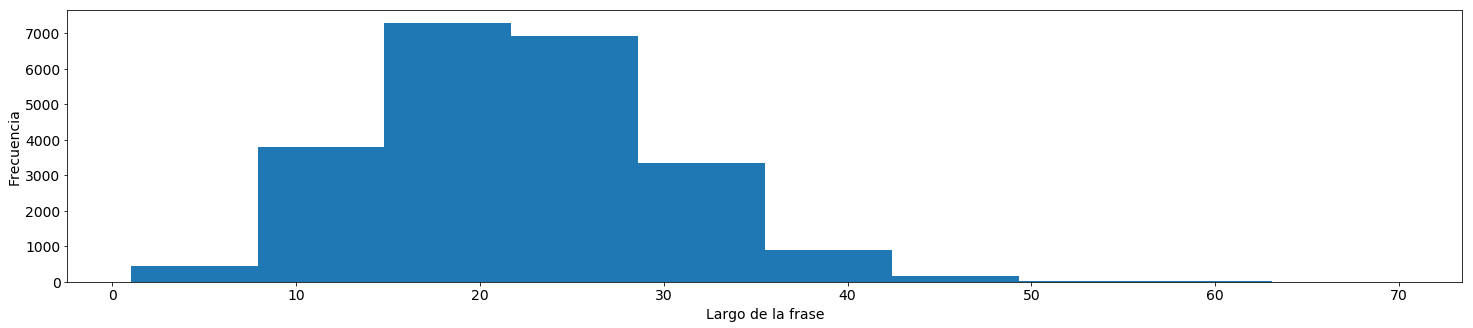

In [79]:
len_of_sentence = [len(i) for i in dataX_raw]
plt.figure(figsize = (25,5))

plt.hist(len_of_sentence)

plt.xlabel("Largo de la frase")
plt.ylabel("Frecuencia")

plt.show()

In [80]:
freq_of_words = {}

for fila in dataset.values[:]:# dataset.values[:n_used]:
    if fila[0] not in freq_of_words:
        freq_of_words[fila[0]] = 0
    freq_of_words[fila[0]]+=1
    
a = [ (freq_of_words[i], i) for i in freq_of_words]
a.sort(reverse=True)
# top_15 = a[:40]

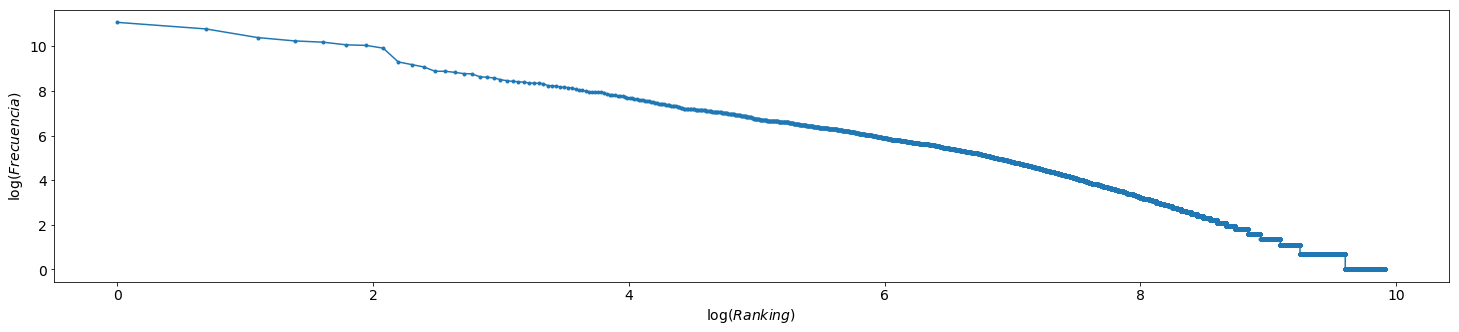

In [82]:
# Voy a transformar el arreglo top_15 para que sea graficable
X = []
Y = []

for i in range(len(a)): #range(len(top_15)):
    tupla = a[i] # top_15[i]
    Y.append( np.log(tupla[0]) )
    X.append( np.log(i+1) )
    legends.append( tupla[1] )

plt.figure(figsize = (25,5))

plt.plot(X, Y, '.-')

plt.xlabel("$\log(Ranking)$")
plt.ylabel("$\log(Frecuencia)$")

plt.show()

## c)
Para representar cada posible *tag* y *lemma* de modo que la red pueda manejarlo, será necesario codificarlos a un número único (*indice*) ¿Cuántos *tags* y *lemmas* distintos existen?  Comente sobre el significado del *tag* para cada *lemma*. **Finalmente mida el largo máximo de entre todas las sentencias**.

In [83]:
n_labels = len(labels)
lab2idx = {t: i for i, t in enumerate(labels)}
dataY = [[lab2idx[ner] for ner in ner_tags ] for ner_tags in dataY_raw] #Converting tags to indexs

n_lemmas = len(lemmas)
lemma2idx = {w: i for i, w in enumerate(lemmas)} 
dataX = [[lemma2idx[lemma] for lemma in sentence ] for sentence in dataX_raw] #Converting text to indexs

In [85]:
print("Cantidad de tags distintos: ", n_labels)
print("Cantidad de lemmas distintos: ", n_lemmas)

Cantidad de tags distintos:  17
Cantidad de lemmas distintos:  12450


Hay 17 tags distintos, 12450 lemmas distintos. La sentencia más larga dentro del caso de estudio (primeras 500000 palabras) es de 70 palabras (ver pregunta **a**).

## d)
Debido a la distinta extensión de textos se deberá realizar padding para estandarizar el largo, considere algun carácter especial no presente en el vocabulario para codificar el espacio en blanco en ambos (entrada y salida), por ejemplo si el largo máximo es de 4 y se tiene la sentencia "the rocket" codificada como [32,4] será necesario agregar un lemma que codificado significará el fin de la sentencia "the rocket ENDPAD ENDPAD" que codificado quedará como [32,4,N, N]. Decida, respecto al cómo funciona una red recurrente y su memoria, sobre qué le parece más conveniente al momento de rellenar con un valor especial ¿Al principio o al final de la sentencia? Comente